# import libraries

1) to start the docker: docker run -it --gpus all -p 8888:8888 -e JUPYTER_TOKEN=jyu -v /home/agschlitzer/Downloads/docker/aibats/:/app tverous/pytorch-notebook 
2) need to pip install pandas matplotlib seaborn scikit-learn pytorch_tabular wandb
3) jupyter nbconvert --execute --to notebook AI-BATs_FTtransformer20241022.ipynb

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch

from pytorch_lightning.loggers import CSVLogger
from pytorch_tabular import TabularModel
from pytorch_tabular.models import (
    CategoryEmbeddingModelConfig,
    FTTransformerConfig,
    TabNetModelConfig,
    GANDALFConfig,
)
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
    ExperimentConfig,
)
from pytorch_tabular.models.common.heads import LinearHeadConfig
from pytorch_lightning.strategies import DDPStrategy

# definitions

## load tabular and labels

In [2]:
# Load protein data with row and column names and labels from separate file, aligning by sample names
def load_data(protein_file, labels_file, label_col_1, label_col_2):
    # Load the protein matrix from the first file with index_col=0 to preserve row names (samples)
    protein_data = pd.read_csv(protein_file, index_col=0)  # Keeps sample names as the index

    # Transpose the data so that it's in sample x protein format
    protein_data = protein_data.T

    # Load the labels from the second file
    labels = pd.read_csv(labels_file, index_col=1)  # Assume sample names/IDs are in the 2nd column (index_col=1)

    # Ensure that both dataframes are aligned by sample names
    common_samples = protein_data.index.intersection(labels.index)  # Find common sample names
    protein_data = protein_data.loc[common_samples]  # Reorder protein data based on common sample names
    labels = labels.loc[common_samples]  # Reorder labels based on common sample names

    # Extract the two specified columns from the labels file
    labels_1 = labels[label_col_1]  # First label column specified by label_col_1
    labels_2 = labels[label_col_2]  # Second label column specified by label_col_2
    
    # Encode both sets of labels
    #label_encoder_1 = LabelEncoder()
    #labels_1 = label_encoder_1.fit_transform(labels_1)

    #label_encoder_2 = LabelEncoder()
    #labels_2 = label_encoder_2.fit_transform(labels_2)

    # Add the two target columns to the protein data
    protein_data["target_1"] = labels_1
    protein_data["target_2"] = labels_2

    return protein_data


## split data based on outcome labels

In [3]:
# Stratified split based on outcome labels
def stratified_split(protein_data):
    # Create a combined label for stratification by concatenating the two target columns
    protein_data['combined_target'] = protein_data['target_1'].astype(str) + "_" + protein_data['target_2'].astype(str)
    
    # Perform stratified train-test split based on the combined label
    train_data, test_data = train_test_split(
        protein_data, test_size=0.2, stratify=protein_data['combined_target'], random_state=42
    )
    
    # Drop the combined target column as it's no longer needed
    train_data = train_data.drop(columns=['combined_target'])
    test_data = test_data.drop(columns=['combined_target'])
    
    return train_data, test_data

# load matrix and label data

In [4]:
# Load the data from separate protein and labels files
protein_file = '30percent_imputed_matrix.csv'  # Replace with your actual file path for the protein data
labels_file = 'sample_labels.csv'  # Replace with your actual file path for the labels data
target_1_col = "tissue"
target_2_col = "diet"
protein_data = load_data(protein_file, labels_file,target_1_col,target_2_col)

## split data into training and test

In [5]:
# Perform stratified train-test split
train_data, test_data = stratified_split(protein_data)

## train-test data distribution

In [6]:
def plot_frequency_distribution(train_data, test_data, target_column):
    """
    Plots the frequency distribution of a target column for both train and test datasets.
    
    Args:
        train_data (pd.DataFrame): The training dataset.
        test_data (pd.DataFrame): The test dataset.
        target_column (str): The column name of the target to plot the frequency distribution for.
    """
    # Get value counts for the target column in both train and test datasets
    train_target_counts = train_data[target_column].value_counts().reset_index()
    test_target_counts = test_data[target_column].value_counts().reset_index()

    # Rename columns for clarity
    train_target_counts.columns = ['Category', 'Count']
    test_target_counts.columns = ['Category', 'Count']

    # Add a column to indicate the dataset
    train_target_counts['Dataset'] = 'Train'
    test_target_counts['Dataset'] = 'Test'

    # Combine both DataFrames into one for plotting
    combined_df = pd.concat([train_target_counts, test_target_counts])

    # Plot the frequency distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Category', y='Count', hue='Dataset', data=combined_df)

    # Add labels and title
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title(f'Frequency Distribution of {target_column} in Train and Test Datasets')

    # Show the plot
    plt.show()

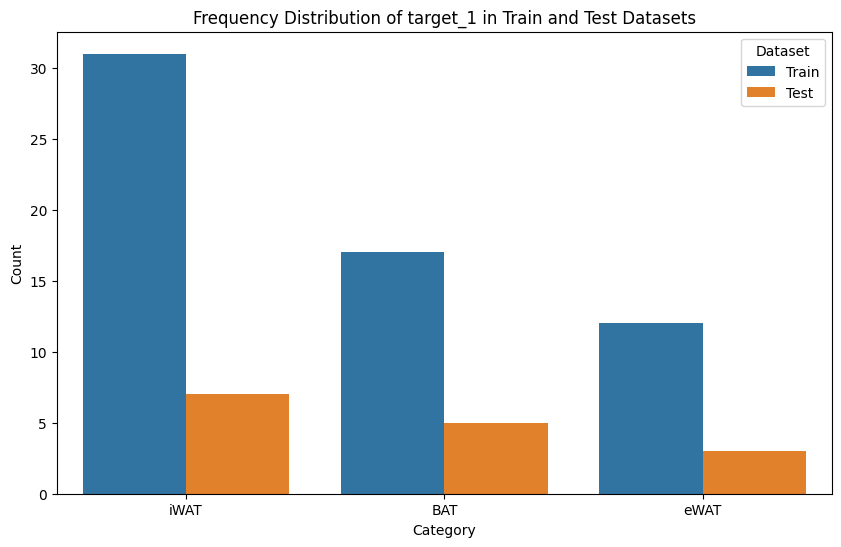

In [7]:
plot_frequency_distribution(train_data, test_data, 'target_1')

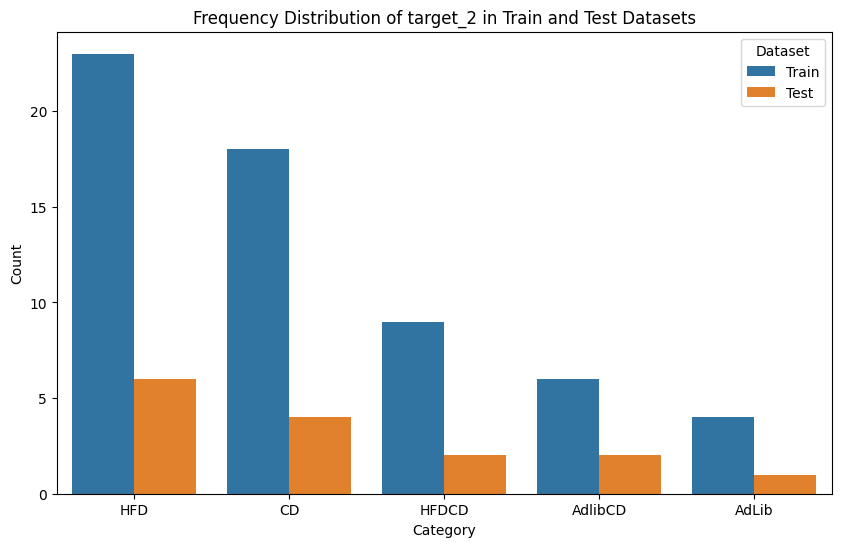

In [8]:
plot_frequency_distribution(train_data, test_data, 'target_2')

# initialize a wandb run

In [9]:
# Step 1: Initialize a WandB run
#wandb.init(project="AI-BATS_FTTransformer_diet")


# FT-Transformer configuration

In [10]:

data_config = DataConfig(
    target=['target_1', 'target_2'],  # Multiple targets for multi-task classification
    continuous_cols=train_data.columns[:-2].tolist(),  # All columns except the target ones
)
data_config = DataConfig(
    target=['target_1'],  # Multiple targets for multi-task classification
    continuous_cols=train_data.columns[:-2].tolist(),  # All columns except the target ones
    num_workers = 4,
)

trainer_config = TrainerConfig(
    auto_lr_find=True,  # Runs the LRFinder to automatically derive a learning rate
    batch_size=32, ## lowered from 1024 to lower CPU usage. powers of 2, between 32 and 256 is typically used. 
                   ##One way to think about it is that smaller batches means that the number of parameter updates per epoch is greater.
    max_epochs=100, ## generally 11 is ideal for most datasets
    devices = 1, ## newly_added to lower CPU usage, seems very efficient
    early_stopping="valid_loss",  # Monitor valid_loss for early stopping
    early_stopping_mode="min",  # Set the mode as min because for val_loss, lower is better
    early_stopping_patience=5,  # No. of epochs of degradation training will wait before terminating
    checkpoints="valid_loss",  # Save best checkpoint monitoring val_loss
    load_best=True,  # After training, load the best checkpoint
)
optimizer_config = OptimizerConfig()

head_config = LinearHeadConfig(
    layers="",  # No additional layer in head, just a mapping layer to output_dim
    dropout=0.1,
    initialization="kaiming",
).__dict__  # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

EXP_PROJECT_NAME = "pytorch-tabular-covertype"

model_config = FTTransformerConfig(
    task="classification",
    num_attn_blocks=3,
    num_heads=4,
    learning_rate=1e-3,
    head="LinearHead",  # Linear Head
    head_config=head_config,  # Linear Head Config
)

#experiment_config = ExperimentConfig(
#    project_name=EXP_PROJECT_NAME,
#    run_name="FTTransformer",
#    exp_watch="gradients",
#    log_target="wandb",
#    log_logits=True,
#)
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    #experiment_config=experiment_config,
    verbose=False,
    suppress_lightning_logger=False,
)

# train and evaluate

In [11]:
# ----------------- Train the Model -----------------
tabular_model.fit(train=train_data, validation=test_data)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-11-03 15:39:52.615373: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 15:39:52.818329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 15:39:52.902049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 15:39:52.935341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS fact

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.012022644346174132
Restoring states from the checkpoint path at /app/.lr_find_dabf164a-8d0b-4e32-81a9-aeae5cc8805d.ckpt
/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where yo

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                  ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ FTTransformerBackbone │ 93.9 K │
│ 1 │ _embedding_layer │ Embedding2dLayer      │  244 K │
│ 2 │ _head            │ LinearHead            │     99 │
│ 3 │ loss             │ CrossEntropyLoss      │      0 │
└───┴──────────────────┴───────────────────────┴────────┘

Trainable params: 338 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 338 K                                                                                                
Total estimated model params size (MB): 1

Output()

/usr/local/lib/python3.10/dist-packages/pytorch_tabular/utils/python_utils.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=map_locatio

In [12]:
# PyTorch Tabular workflow
pred_df = tabular_model.predict(test_data)
pred_df.head()

,BAT_probability,eWAT_probability,iWAT_probability,prediction
Rhabi-Rhabi-VEH2B,0.935557,0.006695,0.057748,BAT
Oeckl-Oeckl-iBAT.T23.WT_4,0.963649,0.009580,0.026772,BAT
Kristina-Kristina-LFQ intensity CD_iWAT_5_3253,0.005713,0.007337,0.986950,iWAT
Oeckl-Oeckl-iWAT.T23.WT_3,0.006551,0.006226,0.987223,iWAT
Kristina-Kristina-LFQ intensity HFD_iWAT_4_2172,0.075506,0.004813,0.919681,iWAT


In [13]:
# ----------------- Evaluate the Model -----------------
result = tabular_model.evaluate(test=test_data)
result

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8666666746139526     │
│         test_loss         │    0.3132587671279907     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3132587671279907, 'test_accuracy': 0.8666666746139526}]

# save the model

In [14]:
tabular_model.model.state_dict()

OrderedDict([('_backbone.add_cls.weight',
              tensor([ 0.0696,  0.1444, -0.0811,  0.1039, -0.0820, -0.0086, -0.1087,  0.1149,
                       0.1809, -0.1533,  0.0948, -0.0078,  0.0725, -0.0244,  0.0670,  0.0233,
                       0.1686,  0.0692, -0.0317,  0.0144, -0.0107, -0.0210, -0.0740,  0.1507,
                      -0.0620, -0.0199, -0.0478, -0.0960, -0.0347, -0.1137,  0.1468, -0.0908])),
             ('_backbone.transformer_blocks.mha_block_0.mha.to_qkv.weight',
              tensor([[ 1.0540e-01, -7.1401e-03, -8.8869e-02,  ...,  6.5104e-02,
                       -1.1537e-01,  1.0957e-02],
                      [ 8.4263e-04, -3.5594e-02,  1.2360e-01,  ..., -3.2193e-02,
                       -1.2931e-02,  1.0434e-01],
                      [ 1.1091e-01,  2.2766e-02, -1.1347e-01,  ...,  1.4928e-01,
                       -9.7784e-02,  1.2238e-01],
                      ...,
                      [-2.1898e-01, -1.0682e-01, -5.7874e-02,  ...,  1.9293e-01,
  

In [15]:
model_save_path = "saved_modelv2"
tabular_model.save_model(model_save_path)